## **Numerical Experiments for Fast Accelerated Proximal Gradient Algorithm**

**NGUYEN Huu Nhan**

**M2 ACSYON, University of Limoges**

In [1618]:
import numpy as np
import matplotlib.pyplot as plt

### **1. Generate data set**

In [1619]:
N = 100
m = 1000

In [1620]:
def scale(x):
    max_x = np.max(np.abs(x))
    return x / max_x

In [1621]:
x0 = scale(np.random.multivariate_normal(np.zeros(N), np.eye(N), m))
y0 = np.ones(m)

In [1622]:
S = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        S[i, j] = np.random.normal(0,1)

x1 = scale(np.random.multivariate_normal(10 / np.sqrt(N) * np.ones(N), S @ S.T, m))
y1 = - np.ones(m)

In [1623]:
X = np.concatenate((x0, -x1)).T

In [1624]:
y = np.concatenate((y0, y1))

### **2. Bisection algorithm for projection operators**

In [1625]:
def bisec(x, r, l, u, tol=1.e-16):
    def alpha(y, t):
        return min(max(l, y - t), u)
    
    n = len(x)
    I = range(n)
    x_max = np.max(x)
    x_min = np.min(x)
    theta_u = x_max - r/n
    theta_l = x_min - r/n

    su = 0
    sl = 0
    sc = 0

    while abs(theta_u - theta_l) > tol:
        theta = (theta_u + theta_l)/2
        uh = u + theta
        lh = l + theta
        Iu = [i for i in I if x[i] >= uh]
        Il = [i for i in I if x[i] <= lh]
        Ic = [i for i in I if i not in Iu and i not in Il]

        delta_su = len(Iu) * u
        delta_sl = len(Il) * l
        sc = sum([alpha(x[i], theta) for i in Ic])

        val = su + delta_su + sl + delta_sl + sc - len(Ic) * theta 

        if val < r:
            theta_u = theta 
            I = Ic + Il
            su = su + delta_su
        elif val > r:
            theta_l = theta
            I = Ic + Iu
            sl = sl + delta_sl
        else:
            break

        if np.prod(np.array([x[i] - theta_u >= l and x[i] - theta_l <= u for i in I])) == 1:
            theta = (su + sl + sc - r) / len(I)
            break

    return np.array([alpha(x[i], theta) for i in range(n)])


### **3. Fast Accelerated Proximal Gradient Algorithm**

In this section, I implement FISTA algorithm with different step-size strategies. The first algorithm uses backtracking and restarting schemes. The second one uses backtracking, decreasing, and restarting strategies. The last one is the fast APG combining all techniques with stabilization.

In [1626]:
def apg_br(f, grad_f, g, prox_g, tol, L, nu, k_max, init):
    def T(L, y):
        return prox_g(1/L, y - 1/L * grad_f(y))

    def qF(L, x, y):
        return f(y) + np.matmul(grad_f(y), x-y) + L/2 * np.linalg.norm(x-y) ** 2

    k = 1
    x = init.copy()
    y = init.copy()
    t = 1
    x_list = [x]
    L_list = [L]
    violation = []

    while k < k_max:
        x_new = T(L, y)
        
        while f(x_new) > qF(L, x_new, y):
            L = L * nu
            x_new = T(L, y)

        test = np.linalg.norm(L*(x_new - T(L, x_new)))
        violation.append(test)

        if test < tol:
            break  

        t_new = (1 + np.sqrt(1 + 4 * t ** 2))/2 
        y_new = x_new + (t-1)/t_new * (x_new - x)

        if np.dot(grad_f(y), x_new - x) > 0:
            t_new = 1
            y_new = x 
            x_new = x

        x = x_new
        y = y_new
        t = t_new
        x_list.append(x)
        L_list.append(L)
        k = k + 1
    
    return x, x_list, L_list, violation

In [1627]:
def apg_bdr(f, grad_f, g, prox_g, tol, L, nu, nd, k_max, init):
    def T(L, y):
        return prox_g(1/L, y - 1/L * grad_f(y))

    def qF(L, x, y):
        return f(y) + np.matmul(grad_f(y), x-y) + L/2 * np.linalg.norm(x-y) ** 2

    k = 1
    t0 = 0
    t1 = 1
    L1 = L
    L0 = L
    x1 = init.copy()
    x0 = init.copy()
    y = init.copy()
    x_list = [x1]
    L_list = [L1]
    violation = []

    while k < k_max:
        x2 = T(L1, y)

        while f(x2) > qF(L1, x2, y):
            L1 = nu * L1
            t1 = (1 + np.sqrt(1 + 4 * L1/L0 * t0 ** 2))/2
            y = x1 + (t0 - 1)/t1 * (x1 - x0)
            x2 = T(L1, y)
        
        test = np.linalg.norm(L1*(x2 - T(L1, x2)))
        violation.append(test)
        
        if test < tol:
            break

        L2 = L1 / nd 
        t2 = (1 + np.sqrt(1 + 4 * L2/L1 * t1 ** 2))/2
        y1 = x2 + (t1 - 1)/t2 * (x2 - x1)

        if np.dot(grad_f(y), x2 - x1) > 0:
            t2 = 1
            t1 = 0
            y1 = x1
            x2 = x1

        x0 = x1.copy()
        x1 = x2.copy()
        y = y1.copy()
        t0 = t1
        t1 = t2
        L0 = L1
        L1 = L2
        k = k + 1
        x_list.append(x1)
        L_list.append(L1)     
    
    return x1, x_list, L_list, violation
        

In [1628]:
def fapg(f, grad_f, g, prox_g, tol, L, nu, nd, delta, k_max, K, init):
    def qF(L, x, y):
        return f(y) + np.matmul(grad_f(y), x-y) + L/2 * np.linalg.norm(x-y) ** 2
    
    def T(L, y):
        return prox_g(1/L, y - 1/L * grad_f(y))
    
    i = 1
    k = 1
    t = 1
    k_re = 0
    x = init.copy()
    y = init.copy()
    x_list = [x]
    L_list = [L]
    violation = []

    while k < k_max:
        x_new = T(L, y)

        if k%10 == 1:
            #backtracking strategy
            while f(x_new) > qF(L, x_new, y):
                L = L * nu
                x_new = T(L, y)
        
        violation.append(np.linalg.norm(L * (T(L,x_new) - x_new)))
        
        if np.linalg.norm(L*(x_new - y)) < tol or (k%100 == 1 and np.linalg.norm(L * (T(L, x_new) - x_new)) < tol):
            x = x_new
            x_list.append(x)
            L_list.append(L)
            break
        
        #decreasing strategy
        L = L/nd

        #update coefficient for momentum
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2

        y_new = x_new + (t - 1)/t_new * (x_new - x)

        if k > k_re + K and (np.dot(grad_f(y), x_new - x) > 0):
            #maintaining top-speed strategy
            k_re = k 
            K = 2 * K
            i = i + 1

            #stabalization strategy
            nd = delta * nd + (1-delta) * 1

            #restarting strategy
            t_new = 1
            y_new = x
            x_new = x
        
        y = y_new
        x = x_new
        t = t_new
        x_list.append(x)
        L_list.append(L)
        k = k + 1
    
    return x, x_list, L_list, violation

### **4. Numerical experiment for $\mu$-SVM**

Finally, I use the implemented algorithms to solve $\mu$-SVM problem with the generated data set in the section 1.

We choose $\mu = 0.5$.

In [1629]:
mu = 0.5

In [1630]:
def g_mu_svm(mu, x):
    if np.dot(x, y) == 0 and np.dot(x, np.ones(2*m)) == 1 and np.prod(np.zeros(2*m) <= x) * np.prod(x <= 1/(2* m * mu) * np.ones(2*m)) == 1:
        return 0
    else:
        return float('inf')

In [1631]:
def prox_mu_svm(mu, x):
    x0 = x[0:m]
    x1 = x[m:]
    return np.concatenate((bisec(x0, 0.5, 0, 1/(2 * m * mu)), 
                           bisec(x1, 0.5, 0, 1/(2 * m * mu))))

In [1632]:
x, x_list, L_list, violation = fapg(lambda x : np.linalg.norm(np.matmul(X, x)) ** 2, lambda x : 2 * np.matmul(X.T, np.matmul(X, x)),
     lambda x: g_mu_svm(mu, x), lambda L, x: prox_mu_svm(mu, x), 
     1.e-6, 1000, 1.1, 1.1, 0.8, 1000, 2, 1/(2*m) * np.ones(2*m))

In [1633]:
x_bdr, x_list_bdr, L_list_bdr, violation_bdr = apg_bdr(lambda x : np.linalg.norm(np.matmul(X, x)) ** 2, lambda x : 2 * np.matmul(X.T, np.matmul(X, x)),
     lambda x: g_mu_svm(mu, x), lambda L, x: prox_mu_svm(mu, x), 
     1.e-6, 1000, 1.1, 1.1, 1000, 1/(2*m) * np.ones(2*m))

In [1634]:
x_br, x_list_br, L_list_br, violation_br = apg_br(lambda x : np.linalg.norm(np.matmul(X, x)) ** 2, lambda x : 2 * np.matmul(X.T, np.matmul(X, x)),
     lambda x: g_mu_svm(mu, x), lambda L, x: prox_mu_svm(mu, x), 
     1.e-6, 1000, 1.1, 1000, 1/(2*m) * np.ones(2*m))

In [1635]:
opt_val = np.linalg.norm(np.matmul(X, x)) ** 2

In [1636]:
val_list = [np.linalg.norm(np.matmul(X, x)) ** 2 - opt_val for x in x_list]
val_list_bdr = [np.linalg.norm(np.matmul(X, x)) ** 2 - opt_val for x in x_list_bdr]
val_list_br = [np.linalg.norm(np.matmul(X, x)) ** 2 - opt_val for x in x_list_br]

The first plot represent violations of the optimality $\| L(T_L(x_k) - x_k)\|$.

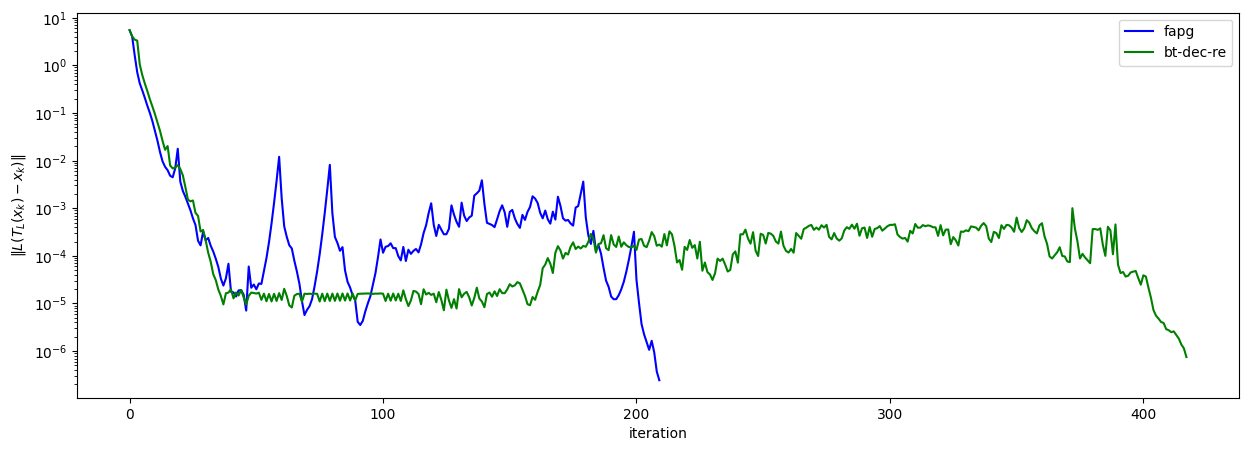

In [1640]:
plt.figure(figsize=(15, 5))
plt.plot(violation, label = 'fapg', color = 'b')
plt.plot(violation_bdr, label = 'bt-dec-re', color = 'g')
plt.xlabel('iteration')
plt.ylabel(r'$\| L(T_L(x_k) - x_k)\|$')
plt.yscale('log')
plt.legend(loc = 'upper right')

The second plot depicts the gap to optimal value $f(x_k) - f(x^*)$.

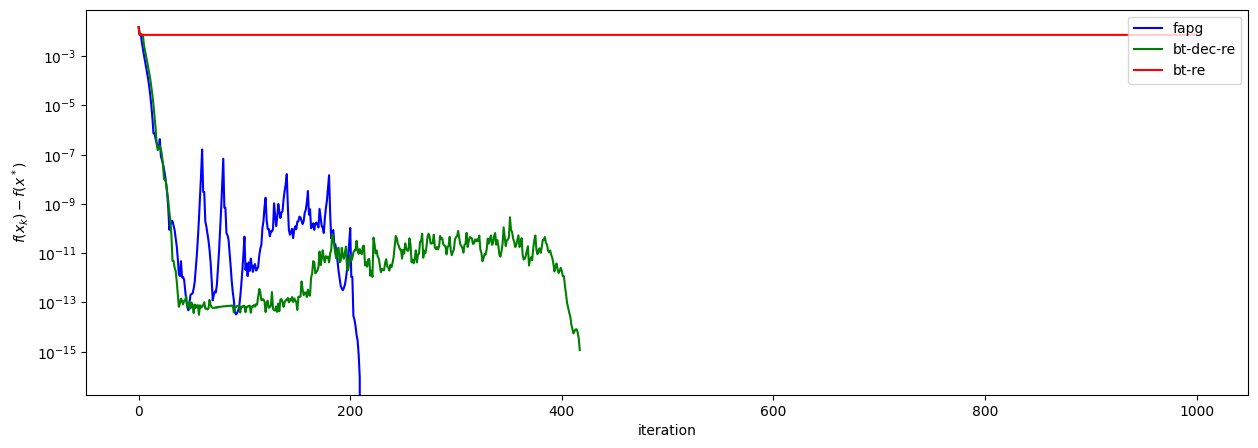

In [1638]:
plt.figure(figsize=(15, 5))
plt.plot(val_list, label = 'fapg', color = 'b')
plt.plot(val_list_bdr, label = 'bt-dec-re', color = 'g')
plt.plot(val_list_br, label = 'bt-re', color = 'r')
plt.yscale('log')
plt.xlabel('iteration')
plt.ylabel(r'$f(x_k) - f(x^*)$')
plt.legend(loc = 'upper right')

The following plot compares the values of constant $L_k$ over iterations of three implemented algorithms.

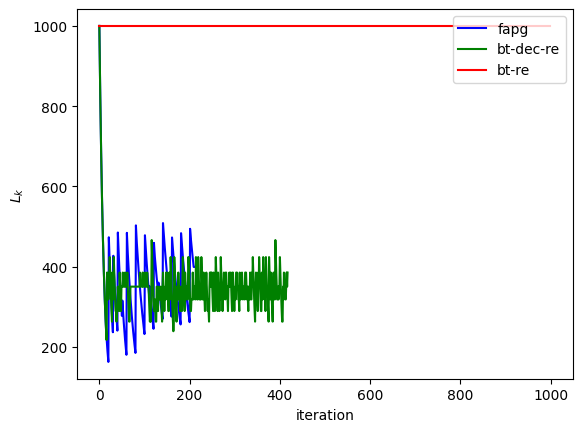

In [1639]:
plt.figure()
plt.plot(L_list, label = 'fapg', color = 'b')
plt.plot(L_list_bdr, label = 'bt-dec-re', color = 'g')
plt.plot(L_list_br, label = 'bt-re', color = 'r')
plt.xlabel('iteration')
plt.ylabel(r'$L_k$')
plt.legend(loc = 'upper right')

**References**

Ito, N., Takeda, A., & Toh, K. (2017). A Unified Formulation and Fast Accelerated Proximal Gradient Method for Classification. *J. Mach. Learn. Res.*, 18, 16:1-16:49